### Order of Steps

Non-Tokenized-Based
- Perform VADER on unprocessed data (case and punctuation sensitive)
- Perform Lowercasing 
- Perform Readability (stopwords, punctuation matters)
- Count Exclamation (efore removing punctuation)
- Remove Punctuation

Tokenized-Based
- Tokenize
- Calculate Lexical Diversity (before removing stopwords)
- Count Superlatives using PoS Tagging
- Stemming 

### 1. Import

In [99]:
# Base Imports
import pandas as pd
import matplotlib.pyplot as plt

# NLTK Imports
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import util
from nltk import pos_tag

# Others
import re
import pickle

# Readability
import textstat
# Boxplot
import seaborn as sns
# Display stuff nice
import textwrap

In [139]:
# Read the first 5,000 rows from each file
df1 = pd.read_csv('archive_kaggle_data/Constraint_Train.csv')
df2 = pd.read_csv('archive_kaggle_data/Constraint_Val.csv')
df3 = pd.read_csv('archive_kaggle_data/Constraint_Test.csv')

# Combine the dataframes
fake_df = pd.concat([df1, df2, df3], ignore_index=True)

# Only keep fake news
fake_df = fake_df[fake_df["label"] == "fake"]

# Replace label with +1
fake_df['label'] = fake_df['label'].replace('fake', 1)

print(fake_df)
print(len(fake_df))


        id                                              tweet  label
2        3  Politically Correct Woman (Almost) Uses Pandem...      1
7        8  Obama Calls Trump’s Coronavirus Response A Cha...      1
8        9  ???Clearly, the Obama administration did not l...      1
9       10  Retraction—Hydroxychloroquine or chloroquine w...      1
11      12  The NBA is poised to restart this month. In Ma...      1
...    ...                                                ...    ...
8551  2132              The novel coronavirus was “man-made.”      1
8553  2134  Swine flu virus is more dangerous than the nov...      1
8555  2136  Donald Trump wrongly claimed that New Zealand ...      1
8557  2138  Nothing screams “I am sat around doing fuck al...      1
8558  2139  Birx says COVID-19 outbreak not under control ...      1

[4080 rows x 3 columns]
4080


In [171]:
# Read in official tweets
official_df = pd.read_csv('tweets_official.csv')

# Create labels
official_df['label'] = -1

# Drop "is covid" column
official_df.drop("is_covid", axis=1, inplace=True)

print(official_df)
print(len(official_df))

                        id                                              tweet  \
0      1286201884903116801  If you have recovered from #COVID19, consider ...   
1      1257336550913970182  RT @DrTedros: Thank you Ireland and Taoiseach ...   
2      1273300573832577024  CDC has information for groups at higher risk ...   
3      1289143516992610305  For those of us celebrating #EidAlAdha make su...   
4      1257673403772928000  RT @NHSuk: Today is World #HandHygiene Day. \n...   
...                    ...                                                ...   
15941  1280765354747342849  Hand washing still plays a key role in protect...   
15942  1252344219470987265  @AudreyAurus1 These claims are categorically f...   
15943  1293520105503100928  How to wear a medical mask safely 👇\n\nFor mor...   
15944  1322223878219960323  The #COVID19 Emergency Committee provided the ...   
15945  1339599142956384256  RT @CDCgov: Rates of #COVID19 continue to incr...   

       label  
0         -1

In [172]:
official_df

,id,tweet,label
0,1286201884903116801,"If you have recovered from #COVID19, consider ...",-1
1,1257336550913970182,RT @DrTedros: Thank you Ireland and Taoiseach ...,-1
2,1273300573832577024,CDC has information for groups at higher risk ...,-1
3,1289143516992610305,For those of us celebrating #EidAlAdha make su...,-1
4,1257673403772928000,RT @NHSuk: Today is World #HandHygiene Day. \n...,-1
...,...,...,...
15941,1280765354747342849,Hand washing still plays a key role in protect...,-1
15942,1252344219470987265,@AudreyAurus1 These claims are categorically f...,-1
15943,1293520105503100928,How to wear a medical mask safely 👇\n\nFor mor...,-1
15944,1322223878219960323,The #COVID19 Emergency Committee provided the ...,-1


In [173]:
# Combine the two data frames

combined_df = pd.concat([fake_df, official_df], ignore_index=True)
print(len(combined_df))

20023


In [174]:
# Mix up the order
combined_df = combined_df.sample(frac=1, random_state=42)

In [175]:
# Load our Emoji and Emoticon Dictionary for the preprocessing

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

### Observe Data

In [176]:
combined_df

,id,tweet,label,length
878,1878,A letter with the logo of Aldi claims that the...,1,132.0
3958,1931,If you maintain social distancing indoors ther...,1,102.0
6052,1353751177603686401,Media briefing on #COVID19 with @DrTedros http...,-1,NaN
2814,5919,"Donald Trump Diagnosed with ADTD, or Attention...",1,125.0
14703,1291392360199462914,Our COVID-19 statistics website has been updat...,-1,NaN
...,...,...,...,...
11284,1271183100438024192,RT @Bakaburg1: Just published! Guidance on pre...,-1,NaN
11964,1260578991401992193,RT @vonderleyen: Sooner or later we will find ...,-1,NaN
5390,1262118447648997381,Protect yourself from #COVID19 while getting g...,-1,NaN
860,1848,Brooklyn Crime Boss Salvatore Goombalini Says ...,1,137.0


In [146]:
# Assume that `articles` is a pandas Series with the text of each article
for i, article in enumerate(combined_df["tweet"]):
    print(f'Article {i+1}:')
    print("Label: ", combined_df["label"].iloc[i], "\n")
    print(combined_df["tweet"].iloc[i], "\n")
    if i > 40:
        break


Article 1:
Label:  1 

NEWS! Man regrets signing up to dating site with username ‘Covid-19’ https://t.co/MIrQBl2hqt https://t.co/GoU4ezkNw1 

Article 2:
Label:  1 

RT @EllenCutch: Coronavirus misinformation is moving offline. A reddit user posted this flyer to the site and told us it had been delive… 

Article 3:
Label:  1 

‘Don’t get ill’: Britain’s 12-point coronavirus plan https://t.co/8u2bozEoDy https://t.co/smdUJaa8i0 

Article 4:
Label:  1 

A message that offers food assistance to people at risk of social exclusion in Spain. 

Article 5:
Label:  1 

Wearing a mask can prevent transmission of Covid-19 

Article 6:
Label:  1 

Metro Manila had an 83% rise in COVID-19 cases in one day. 

Article 7:
Label:  1 

Cocaine cures COVID-19. 

Article 8:
Label:  1 

God tests positive for COVID-19 after church services continue

https://t.co/B0DNDxqn2W https://t.co/cbii7vCaHy 

Article 9:
Label:  1 

Starting in March if you travel outside of the United States you won???t be allowed back

In [177]:
# Compare the length
official_df['length'] = official_df['tweet'].apply(len)
fake_df['length'] = fake_df['tweet'].apply(len)

print(fake_df)

        id                                              tweet  label  length
2        3  Politically Correct Woman (Almost) Uses Pandem...      1     131
7        8  Obama Calls Trump’s Coronavirus Response A Cha...      1      83
8        9  ???Clearly, the Obama administration did not l...      1     100
9       10  Retraction—Hydroxychloroquine or chloroquine w...      1     170
11      12  The NBA is poised to restart this month. In Ma...      1     218
...    ...                                                ...    ...     ...
8551  2132              The novel coronavirus was “man-made.”      1      37
8553  2134  Swine flu virus is more dangerous than the nov...      1      61
8555  2136  Donald Trump wrongly claimed that New Zealand ...      1     241
8557  2138  Nothing screams “I am sat around doing fuck al...      1     184
8558  2139  Birx says COVID-19 outbreak not under control ...      1     102

[4077 rows x 4 columns]


In [178]:
print(fake_df.sort_values(by='length', ascending=False))


        id                                              tweet  label  length
773    774  @giles7452 @William05548637 @CheeseNBranston @...      1     922
4349  4350  @Narvuntien @jimdtweet @MedBennett @TheDisproo...      1     880
6467    48  In our laboratory, we found trace amount of th...      1     723
4147  4148  COVID-19, Take one minute and read. Be underst...      1     695
6872   453  IN ISRAEL NO DEATH FROM C-19 ! He told them a ...      1     633
...    ...                                                ...    ...     ...
2407  2408                            Cocaine cures COVID-19.      1      23
3141  3142                             COVID-19 TEST a FRAUD?      1      22
1883  1884                              COVID-19 is Airborne.      1      21
268    269                               There is no pandemic      1      20
1140  1141                                 Pier Luigi Bersani      1      18

[4077 rows x 4 columns]


In [179]:
print(official_df.sort_values(by='length', ascending=False))


                        id                                              tweet  \
4243   1252345545563058185  @WelshGasDoc @MattHancock @Jeremy_Hunt @JonAsh...   
13141  1273304877981224960  @Sister_Medicine @BorisJohnson @MattHancock @N...   
5840   1334882362170224641  @micalrg @MZ_GOV_PL @a_niedzielski @GIS_gov @g...   
10995  1273305013763407874  @doctor_oxford @NHSEmployers @MattHancock @NHS...   
8669   1265993660816150528  @bbc5live @BenPBradshaw @Emmabarnett @BBCSound...   
...                    ...                                                ...   
15776  1313424372997087232  #EBSpecial on #COVID19 Day 2 https://t.co/X9JO...   
11687  1263773586357010432  Live from #EB147. #COVID19 https://t.co/RuQaUp...   
4649   1282593105930223616  #Keepcool during #COVID19. https://t.co/J3nH6g...   
7102   1313066914306957312     #EBSpecial on #COVID19 https://t.co/5x6BxAUfLW   
31     1313119014915207168     #EBSpecial on #COVID19 https://t.co/z9W0NbaBSD   

       label  length  
4243

In [180]:
# Find outliers. There are three entries that consist of many tweets that were not split. We remove them.
# Other outliers that still exceed the character limit that is expected are caused by replies, which display all the user
# handles the reply refers to. After preprocessing, this issue should be mitigated.

# Remove the three outliers, all with length > 2,000
combined_df = combined_df[combined_df['length'] <= 2000]


In [181]:
# Combine the two data frames again

combined_df = pd.concat([fake_df, official_df], ignore_index=True)
print(len(combined_df))

20023


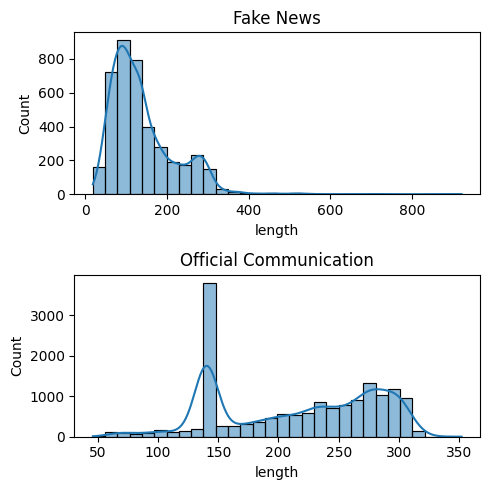

In [182]:
# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot the histogram for the class '1'
sns.histplot(data=combined_df[combined_df['label'] == 1],
             x='length',
             bins=30,
             ax=ax[0],
             kde=True)
ax[0].set_title('Fake News')

# Plot the histogram for the class '-1'
sns.histplot(data=combined_df[combined_df['label'] == -1],
             x='length',
             bins=30,
             ax=ax[1],
             kde=True)
ax[1].set_title('Official Communication')

# Show the plot
plt.tight_layout()
plt.show()


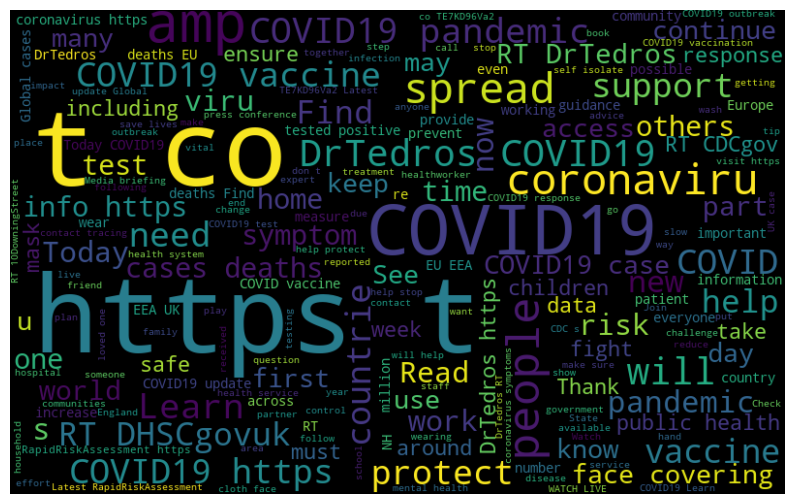

In [183]:
from wordcloud import WordCloud

text = ' '.join(official_df['tweet'].tolist())
wordcloud = WordCloud(width=800,
                      height=500,
                      random_state=21,
                      max_font_size=110).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


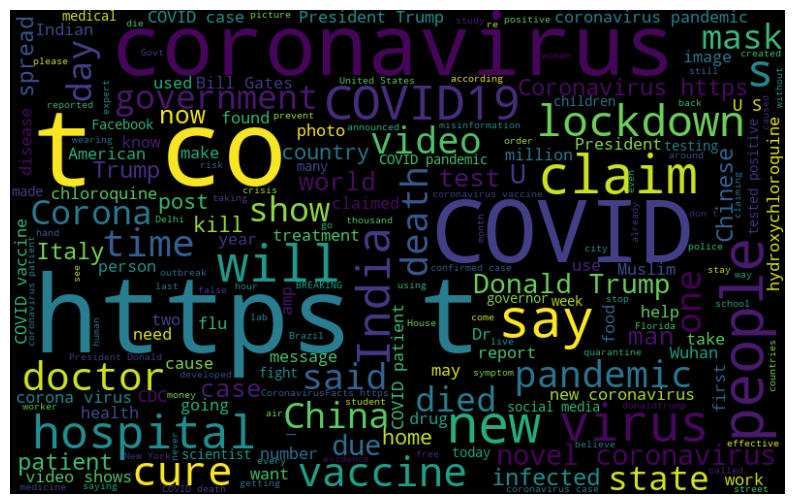

In [184]:
text = ' '.join(fake_df['tweet'].tolist())
wordcloud = WordCloud(width=800,
                      height=500,
                      random_state=21,
                      max_font_size=110).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Preprocessing and Feature Extraction

In [185]:
# Create feature DF
feature_df = pd.DataFrame()
feature_df['label'] = combined_df['label']
print(feature_df)

       label
0          1
1          1
2          1
3          1
4          1
...      ...
20018     -1
20019     -1
20020     -1
20021     -1
20022     -1

[20023 rows x 1 columns]


#### Vader Sentiment

In [186]:
# VADER Sentiment (used on unprocessed text, as punctuation and cases are considered)

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score using VADER
def calculate_sentiment_vader(text):
    return (sid.polarity_scores(text)["compound"])

# Apply the function to each row in the DataFrame
feature_df['sentiment_vader'] = combined_df['tweet'].apply(
    calculate_sentiment_vader)

# Display the DataFrame with the new 'sentiment_vader' column
print(feature_df)


       label  sentiment_vader
0          1           0.0772
1          1          -0.8074
2          1           0.5586
3          1           0.0000
4          1          -0.1531
...      ...              ...
20018     -1           0.9451
20019     -1           0.8567
20020     -1           0.4939
20021     -1          -0.3818
20022     -1           0.9217

[20023 rows x 2 columns]


#### Readability

In [187]:
# Kincaid Readabilility score
# Note that for calculating the Flesch-Kincaid readability score, steps like tokenization,
# lemmatization/stemming, and stop word removal are not necessary because the formula for the
# score relies on the original sentence structure, word count, and syllable count.
# The basic cleaning like lowercasing, and removing HTML tags, noise, punctuation, and special characters would suffice.

# Apply the Flesch-Kincaid grade level test to each row in the DataFrame
feature_df['readability'] = combined_df['tweet'].apply(
    textstat.flesch_kincaid_grade)

# Display the DataFrame with the new 'readability' column
print(feature_df)


       label  sentiment_vader  readability
0          1           0.0772         14.7
1          1          -0.8074         13.9
2          1           0.5586          7.2
3          1           0.0000         14.2
4          1          -0.1531          4.4
...      ...              ...          ...
20018     -1           0.9451         10.3
20019     -1           0.8567         11.8
20020     -1           0.4939         14.7
20021     -1          -0.3818         13.1
20022     -1           0.9217          6.4

[20023 rows x 3 columns]


#### Count Exclamation

In [188]:
# Punctuation
# Propbably more than one exclamation mark is rare, not very serious at all (not even in fake news)

def count_exclamation_marks(text):
    return text.count('!')

# Apply the function to each row in the DataFrame
feature_df['exclamation_marks'] = combined_df['tweet'].apply(
    count_exclamation_marks)

# Display the DataFrame with the new 'exclamation_marks' column
print(feature_df)


       label  sentiment_vader  readability  exclamation_marks
0          1           0.0772         14.7                  0
1          1          -0.8074         13.9                  0
2          1           0.5586          7.2                  0
3          1           0.0000         14.2                  0
4          1          -0.1531          4.4                  0
...      ...              ...          ...                ...
20018     -1           0.9451         10.3                  0
20019     -1           0.8567         11.8                  0
20020     -1           0.4939         14.7                  0
20021     -1          -0.3818         13.1                  0
20022     -1           0.9217          6.4                  0

[20023 rows x 4 columns]


### Preprocessing

In [189]:
# Convert Emojis and Emoticons
def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(
            r'(' + emot + ')',
            "_".join(Emoji_Dict[emot].replace(",",
                                              "").replace(":",
                                                          "").split()), text)
    return text


def convert_emoticons_to_word(text):
    for emot in Emoticon_Dict:
        text = re.sub(u'(' + emot + ')',
                      "_".join(Emoticon_Dict[emot].replace(",",
                                                           "").split()), text)
    return text


In [190]:
def preprocess_tweet(tweet):
    # Remove @user_handles
    tweet = re.sub(r'\B@[\w]*', '', tweet)
    # Remove URL
    tweet = re.sub(r"https?:\/\/t.co\/[\w]*", '', tweet)
    # Remove hastags in front of words
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    # Replace '&amp'
    tweet = re.sub(r'&amp;', '&', tweet)
    # Remove numbers
    tweet = re.sub(r"\b\d+((\.|\,)\d+)?\b", '', tweet)

    # Remove punctuation
    tweet = ''.join([ch for ch in tweet if ch.isalnum() or ch.isspace()])

    # Lowercase
    tweet = tweet.lower()
    # Replace Emoji with word
    tweet = convert_emoticons_to_word(tweet)
    # Replace Emoticon with word
    tweet = convert_emoticons_to_word(tweet)
    # Tokenize tweet
    tweet = nltk.word_tokenize(tweet)
    # return final tweet
    return tweet

In [191]:
# Call preprocessing function
combined_df['preprocessed'] = combined_df['tweet'].apply(
    preprocess_tweet)

In [192]:
# Lexical Diversity (before removing stopwords)

def lexical_diversity(words):
    # Compute the number of unique words (types)
    types = set(words)
    # Compute the total number of words (tokens)
    tokens = len(words)
    # Compute the type-token ratio (TTR)
    ttr = len(types) / tokens if tokens > 0 else 0
    return ttr

# Apply the function to each text in your DataFrame
feature_df['lexical_diversity'] = combined_df['preprocessed'].apply(lexical_diversity)


In [162]:
# Remove stop words
# stop_words = set(stopwords.words('english'))

# combined_df['preprocessed'] = combined_df['preprocessed'].apply(
#   lambda x: [word for word in x if word not in stop_words])


In [193]:
# Count Superlatives by PoS Tagging

def count_superlatives(words):

    # Tag parts of speech
    tagged_words = pos_tag(words)

    # Count superlatives
    superlatives = sum(1 for word, pos in tagged_words
                       if pos in {'JJS', 'RBS'})

    return superlatives


# Apply the function to each text in your DataFrame
feature_df['superlatives'] = combined_df['preprocessed'].apply(
    count_superlatives)


#### Preprocessing Step 2

In [194]:
# Stemming
stemmer = nltk.PorterStemmer()

combined_df['preprocessed'] = combined_df['preprocessed'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x]))


In [195]:
# Handling Negations (we do it in the end, because it would impact removing stopwords,
# lexical diversity and counting superlatives otherwise)


# Handling negations
def handling_negations(words):
    words = nltk.sentiment.util.mark_negation(words)
    return " ".join(text)


combined_df['preprocessed'] = combined_df['preprocessed'].apply(
    handling_negations)


KeyboardInterrupt: 

In [198]:
# Compare the length
combined_df['length_preprocessed'] = combined_df['preprocessed'].apply(len)
combined_df

,id,tweet,label,length,preprocessed,length_preprocessed
0,3,Politically Correct Woman (Almost) Uses Pandem...,1,131,polit correct woman almost use pandem as excus...,89
1,8,Obama Calls Trump’s Coronavirus Response A Cha...,1,83,obama call trump coronaviru respons a chaotic ...,52
2,9,"???Clearly, the Obama administration did not l...",1,100,clearli the obama administr did not leav ani k...,82
3,10,Retraction—Hydroxychloroquine or chloroquine w...,1,170,retractionhydroxychloroquin or chloroquin with...,128
4,12,The NBA is poised to restart this month. In Ma...,1,218,the nba is pois to restart thi month in march ...,151
...,...,...,...,...,...,...
20018,1280765354747342849,Hand washing still plays a key role in protect...,-1,276,hand wash still play a key role in protect you...,215
20019,1252344219470987265,@AudreyAurus1 These claims are categorically f...,-1,314,these claim are categor fals to share disinfor...,211
20020,1293520105503100928,How to wear a medical mask safely 👇\n\nFor mor...,-1,119,how to wear a medic mask safe for more inform ...,56
20021,1322223878219960323,The #COVID19 Emergency Committee provided the ...,-1,126,the covid19 emerg committe provid the follow a...,82


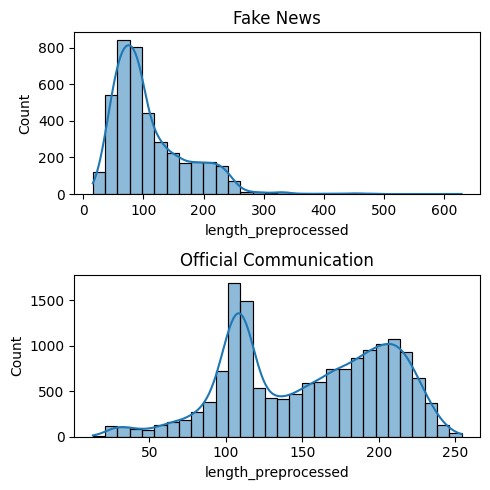

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot the histogram for the class '1'
sns.histplot(data=combined_df[combined_df['label'] == 1],
             x='length_preprocessed',
             bins=30,
             ax=ax[0],
             kde=True)
ax[0].set_title('Fake News')

# Plot the histogram for the class '-1'
sns.histplot(data=combined_df[combined_df['label'] == -1],
             x='length_preprocessed',
             bins=30,
             ax=ax[1],
             kde=True)
ax[1].set_title('Official Communication')

# Show the plot
plt.tight_layout()
plt.show()


In [200]:
print(combined_df.sort_values(by='length_preprocessed', ascending=False))


                        id                                              tweet  \
3075                    48  In our laboratory, we found trace amount of th...   
1970                  4148  COVID-19, Take one minute and read. Be underst...   
3270                   453  IN ISRAEL NO DEATH FROM C-19 ! He told them a ...   
1772                  3746  Mask wearers beware. A caller to a radio talk ...   
3013                  6315  Mask wearers beware. A caller to a radio talk ...   
...                    ...                                                ...   
4025                  2033                      COVID-19 existed before 2019.   
881                   1884                              COVID-19 is Airborne.   
12546  1323301149953396741  "...Thailand..."-@DrTedros #COVID19\n\nhttps:/...   
6396   1323301148749692929  "...Rwanda..."-@DrTedros #COVID19\n\nhttps://t...   
5691   1323301152365125632  "...Italy..."-@DrTedros #COVID19 \n\nhttps://t...   

       label  length       

In [210]:
# Even after preprocessing, we note that there are some more outliers in our
# fake news dataset. This is because supposingly not all posts stem from Twitter
# (e.g. some are from FB, Instagram, etc.). This per se is not a problem, but there
# shouldn't be a systematic difference to the ones we obtain from the scraped
# official communication oens. Thus, we choose to exclude any posts with a length higher
# than 300. 

print(
    len(combined_df[(combined_df['length'] >= 300)
                    & (combined_df['label'] == -1)]))

print(
    len(combined_df[(combined_df['length'] >= 350)
                    & (combined_df['label'] == 1)]))


1247
140


In [211]:
# Exclude all posts of length > 300

combined_df = combined_df[combined_df['length'] <= 300]
print(len(combined_df))

18788


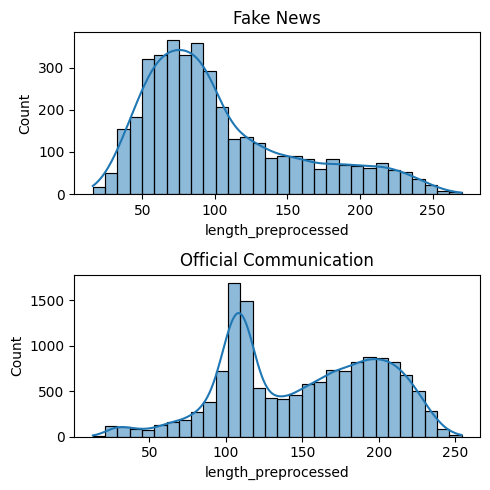

In [212]:
# Create a figure and axes
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

# Plot the histogram for the class '1'
sns.histplot(data=combined_df[combined_df['label'] == 1],
             x='length_preprocessed',
             bins=30,
             ax=ax[0],
             kde=True)
ax[0].set_title('Fake News')

# Plot the histogram for the class '-1'
sns.histplot(data=combined_df[combined_df['label'] == -1],
             x='length_preprocessed',
             bins=30,
             ax=ax[1],
             kde=True)
ax[1].set_title('Official Communication')

# Show the plot
plt.tight_layout()
plt.show()


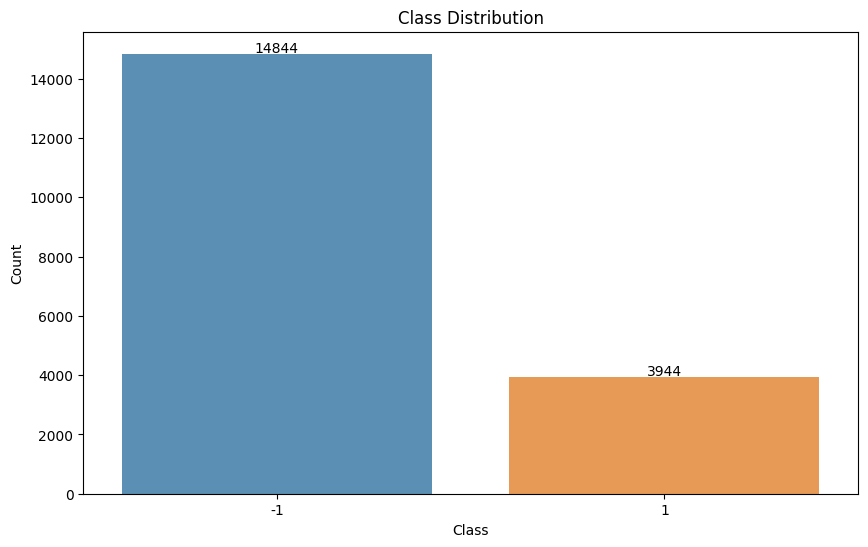

In [214]:
# Count instances of each class
class_counts = combined_df['label'].value_counts()

# Plot
plt.figure(figsize=(10, 6))

# Create a bar plot with seaborn
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Add counts on top of the bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center')

plt.show()


### Feature Selection

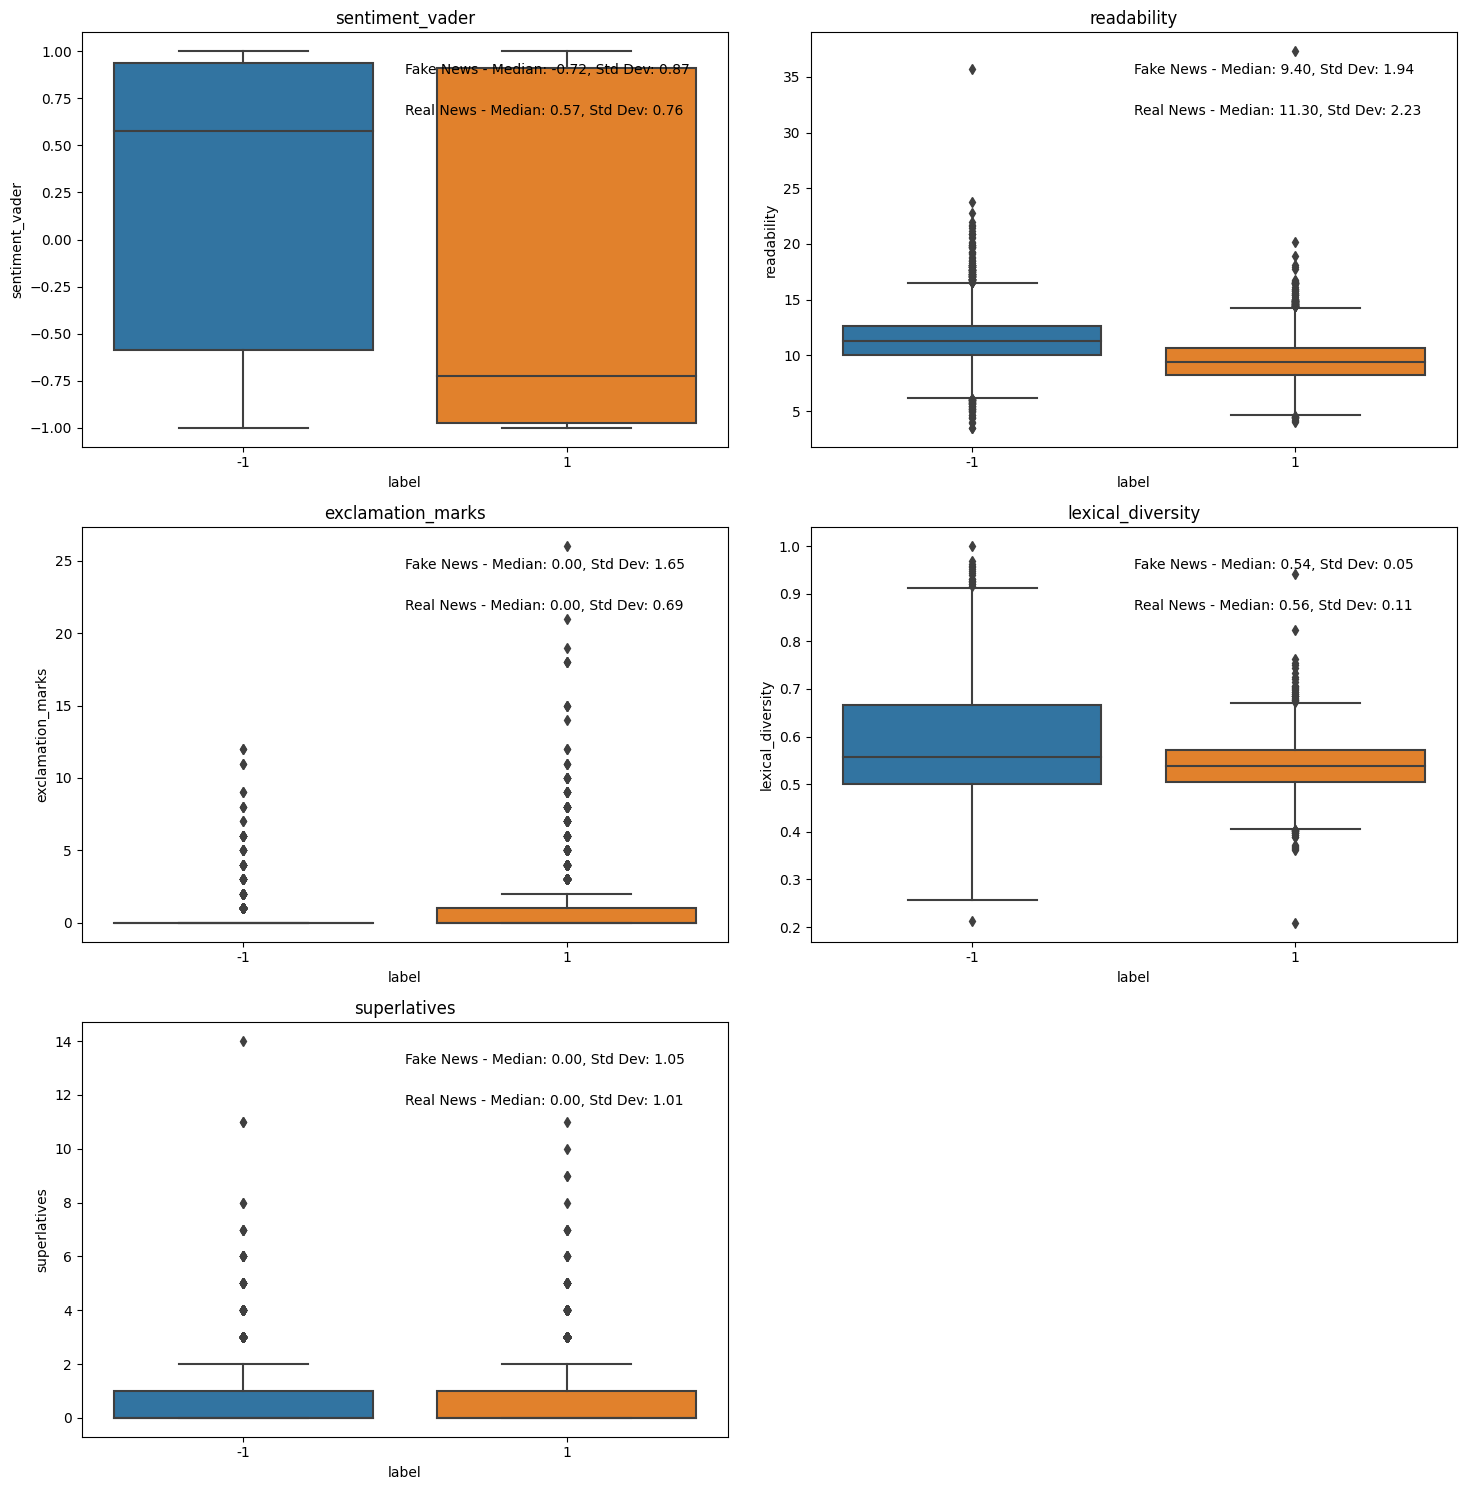

In [146]:

features = feature_df.columns.drop('label')

# Define the number of rows and columns for the subplot grid
n = len(features)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()  # Flatten to make indexing easier

for i, feature in enumerate(features):
    # Calculate median and standard deviation for the feature by class
    median_fake = feature_df[feature_df['label'] == 1][feature].median()
    std_dev_fake = feature_df[feature_df['label'] == 1][feature].std()

    median_real = feature_df[feature_df['label'] == -1][feature].median()
    std_dev_real = feature_df[feature_df['label'] == -1][feature].std()

    # Create the boxplot
    sns.boxplot(x='label', y=feature, data=feature_df, ax=axs[i])

    # Set the title with median and standard deviation
    axs[i].set_title(f'{feature}')

    # Add the calculated stats in the plot
    axs[i].text(0.5, 0.9, f'Fake News - Median: {median_fake:.2f}, Std Dev: {std_dev_fake:.2f}',
                transform=axs[i].transAxes)
    axs[i].text(0.5, 0.8, f'Real News - Median: {median_real:.2f}, Std Dev: {std_dev_real:.2f}',
                transform=axs[i].transAxes)

# Remove extra subplots
if len(features) < len(axs):
    for i in range(len(features), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


### Baseline Classififer

In [147]:
# shuffle the feature_df
feature_df = feature_df.sample(frac=1, random_state=42)

In [148]:
### Linear SVM

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Separate features and labels
X = feature_df.drop('label', axis=1)
y = feature_df['label']

# Split the data into training and testing sets (shuffle by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create and fit the model
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = model.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'The accuracy of the Linear SVM model is: {accuracy*100:.2f}%')


The accuracy of the Linear SVM model is: 72.80%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
